# Tennisanalyse Datensatz Baden
In diesem Notebook analysieren wir die Daten, die mit der Zed 2 Kamera von Stereolabs aufgenommen wurden. Das Spiel wurde im Bareggcenter Baden aufgenommen.

In [25]:
#Importieren der benötigten Bibliotheken
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Einleitung
Zur verfügung der Analyse haben wir zwei Dataframes. Ein Dataframe mit den gelabelten Daten die von uns mit der Aufnahme erzeugt wurden und ein Dataframe mit den Daten die von der Kamera erzeugt wurden.

In [26]:
#Einlesen der Dataframes 
df_cam = pd.read_csv("../Dataframe/df_detected_objects_game.csv")
df_labels = pd.read_csv("../Dataframe/tennis_label_v2.csv", sep=";")

### Beschreibung Kamera Dataframe

In [27]:
df_cam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42571 entries, 0 to 42570
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frame           42571 non-null  int64  
 1   object_id       42571 non-null  int64  
 2   object_label    42571 non-null  object 
 3   confidence      42571 non-null  float64
 4   tracking_state  42571 non-null  object 
 5   x               42565 non-null  float64
 6   y               42565 non-null  float64
 7   z               42565 non-null  float64
 8   vx              42565 non-null  float64
 9   xy              42565 non-null  float64
 10  vz              42565 non-null  float64
 11  width           42571 non-null  float64
 12  height          42571 non-null  float64
 13  length          42571 non-null  float64
 14  head_x          0 non-null      float64
 15  head_y          0 non-null      float64
 16  head_z          0 non-null      float64
dtypes: float64(13), int64(2), objec

Die Kamera gibt folgende Daten aus: 
- frame: Frame Nummer
- object_id: ID der Person die erkennt wurde
- object_label: Label welches Objekt erkannt wurde
- confidence: Wahrscheinlichkeit wie sicher die Kamera ist, dass das Objekt erkannt wurde
- tracking_state: Status der Erkennung
- x: x-Koordinate des Objekts
- y: y-Koordinate des Objekts
- z: z-Koordinate des Objekts
- vx: Geschwindigkeit in x-Richtung
- xy: Geschwindigkeit in y-Richtung
- vz: Geschwindigkeit in z-Richtung
- width: Breite des Objekts
- height: Höhe des Objekts
- length: Länge des Objekts
- head_x: x-Koordinate des Kopfs
- head_y: y-Koordinate des Kopfs
- head_z: z-Koordinate des Kopfs

Insgesamt stehen uns 42571 Observationen mit 17 Features für die Analyse zur Verfügung.

### Beschreibung Label Dataframe

In [28]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Frame       169 non-null    int64  
 1   Status      64 non-null     object 
 2   Schlag _p1  75 non-null     object 
 3   Schlag _p2  62 non-null     object 
 4   Satz        3 non-null      float64
 5   Fehler_p1   22 non-null     object 
 6   Fehler_p2   10 non-null     object 
dtypes: float64(1), int64(1), object(5)
memory usage: 9.4+ KB


Die gelabelten Daten enthalten folgende Informationen:
- Frame: Frame Nummer wo ein oder mehrere Labels gesetzt wurde
- Status: Spiel Status (Aktiv oder Inaktiv)
- Schlag Spieler 1: Schlag des Spielers 1 (Anschlag, Fronthand, Backhand)
- Schlag Spieler 2: Schlag des Spielers 2 (Anschlag, Fronthand, Backhand)
- Satz: Satz Nummer
- Fehler_p1: Fehler des Spielers 1 (Netz, Out, Doppelfehler, Anschlagfehler)
- Fehler_p2: Fehler des Spielers 2 (Netz, Out, Doppelfehler, Anschlagfehler)

Insgesamt sind 169 Observationen vorhanden mit 7 Features.

# Hilfe Funktionen

In diesem Abschnitt sind alle Funktion die wird benötigen um die Daten zu wranglen und zu analysieren.

### Basis Transformation

In [29]:
def tennisfeld(r, P1, P2, P3):
    # P1, P2, P3 sind Kalibrierungspunkte
    # r ist der Punkt der transformiert werden soll
    # P1 Linke Ecke an der Grundlinie X Seitenlinie Einzelfeld
    # P2 Rechte Ecke an der Grundlinie X Seitenlinie Einzelfeld
    # P3 Mittelpunkt am Netz
    r1 = P2 - P1
    r3 = P3 - 0.5*(P1 + P2)
    # Basisvektoren
    r1u = r1 / np.sqrt(np.dot(r1, r1))
    r3u = r3 / np.sqrt(np.dot(r3, r3))
    r2u = np.cross(r1u, r3u)
    # Translation
    T0 = P3
    # Rotation
    M1 = np.c_[r1u, r2u, r3u]
    M1_inv = np.linalg.inv(M1)
    # Abbildung
    return np.inner(M1_inv, (r - T0))


### Tennisfeld zeichnen

In [30]:
def drawTennisField():
    plt.plot([4.11, 4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline rechts
    plt.plot([5.48, 5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline rechts
    plt.plot([-4.11, -4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline links
    plt.plot([-5.48, -5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline links
    plt.plot([0, 0], [-6.40, 6.40], 'k', lw=2) # Center Service Line
    plt.plot([-5.48, 5.48], [0, 0], 'k', lw=2) # Net
    plt.plot([-5.48, 5.48], [11.89, 11.89], 'k', lw=2) # Baseline oben
    plt.plot([-5.48, 5.48], [-11.89, -11.89], 'k', lw=2) # Baseline unten
    plt.plot([-4.11, 4.11], [-6.40, -6.40], 'k', lw=2) # Service Line unten
    plt.plot([-4.11, 4.11], [6.40, 6.40], 'k', lw=2) # Service Line oben

### Zonen auf dem Feld

In [31]:
def zonen(y):
    # y ist die Länge entlang der Seitenlinie
    abs_y = abs(y)
    if 6.4 > abs_y:  # Vom Netz bis zur Aufschlaglinie
        return "Sehr Offensiv"
    elif 11 > abs_y:  #Bis fast zur Grundlinie
        return "Offensiv"
    elif 12.1 > abs_y:  # Etwas hinter der Grundlinie
        return "Neutral"
    else:  # Deutlich hinter der Grundlinie
        return "Defensiv"


### Position auf dem Feld

In [32]:
def position(x):
    # x ist die Länge entlang der Grundlinie
    def_grenze = 1.5
    if x > def_grenze:
        return "Rechts"
    elif x < -def_grenze:
        return "Links"
    else:
        return "Mitte"


### Winkelberechnung

In [33]:
def calculate_angle(row):
    dx = row['new_x_Player2'] - row['new_x_Player1']
    dz = row['new_z_Player2'] - row['new_z_Player1']
    angle = np.degrees(np.arctan2(dz, dx))
    return angle

# Datawrangling

Das Datawrangling beschränkt sich grössten Teils auf den Datensatz der Kamera, da in dem Gelabelten Datensatz die Fehler sehr gering sein sollten.

### Suche nach auffälligen Werten

In [34]:
df_cam.describe(include="all")

,frame,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,vz,width,height,length,head_x,head_y,head_z
count,42571.000000,42571.000000,42571,42571.000000,42571,42565.000000,42565.000000,42565.000000,42565.000000,42565.000000,42565.000000,42571.000000,42571.000000,42571.000000,0.0,0.0,0.0
unique,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Person,NaN,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,42571,NaN,42571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,12936.981725,39.755138,NaN,63.735954,NaN,-0.109782,-3.339812,14.696553,0.000406,-0.001407,0.004903,0.689585,1.576297,0.689585,NaN,NaN,NaN
std,7573.145119,25.439970,NaN,25.870242,NaN,2.065129,2.749499,9.060418,0.699196,0.263332,0.889929,0.129346,0.238112,0.129346,NaN,NaN,NaN
min,3.000000,0.000000,NaN,20.056150,NaN,-6.107420,-7.289750,1.034460,-11.140330,-4.515370,-30.994610,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,6369.000000,15.000000,NaN,36.938480,NaN,-1.704950,-6.394670,5.379070,-0.308050,-0.148240,-0.464870,0.611390,1.384240,0.611390,NaN,NaN,NaN
50%,12969.000000,40.000000,NaN,77.539060,NaN,-0.230250,-2.868060,13.178980,0.011250,-0.007980,0.032260,0.667550,1.658360,0.667550,NaN,NaN,NaN
75%,19501.500000,61.000000,NaN,87.011720,NaN,1.405960,-0.549730,24.749300,0.289270,0.142520,0.502440,0.737245,1.768505,0.737240,NaN,NaN,NaN


Einige Spalten sind haben noch nicht den richtigen Datentyp. Die Spalten x_head, y_head und z_head können wir entfernen, da sie keine Werte enthalten. Die Spalten object_label und tracking_state haben nur eine Ausprägung und können auch entfernt werden.

In [35]:
#Alle Head Koordinaten entfernen, da diese keine Werte enthalten
df_cam.drop(columns=["head_x", "head_y", "head_z", "object_label", "tracking_state"], axis=1, inplace=True)

In [36]:
# Änder der Datentypen
df_cam["object_id"] = df_cam["object_id"].astype("category")

### Koordinaten der Kamera auf das Tennisfeld projizieren

Als nächstes müssen wir die Koordinaten der Kamera auf das Tennisfeld projizieren. Dazu benötigen wir die Koordinaten der Kamera auf dem Tennisfeld. Diese Kalibrierungspunkte sind bei uns die Ecke der Grundlinie und der Seitenlinie des einzel Feldes und der Mittelpunkt des Netzes.

Text(0.5, 1.0, 'Kalibrierungspunkte auf dem Tennisfeld')

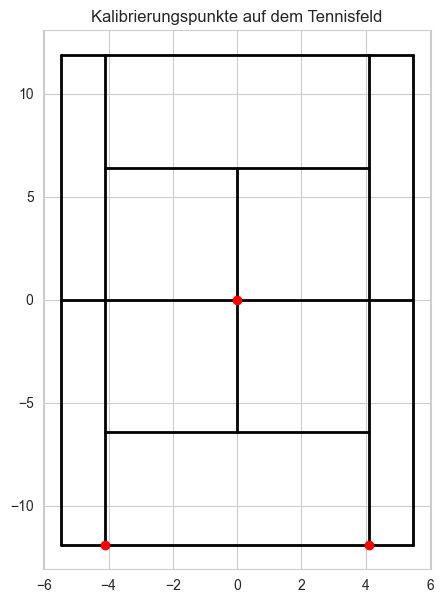

In [55]:
plt.figure(figsize=(5, 7))
drawTennisField()
plt.plot([0], [0], "ro")
plt.plot([-4.11], [-11.89], "ro")
plt.plot([4.11], [-11.89], "ro")
plt.title("Kalibrierungspunkte auf dem Tennisfeld")

Achtung! Stereolabs hat verschieden Koordinatensysteme. In unserem Fall muss die Z-Achse umgedreht werden, da die Kamera die Z-Achse negativ ausgibt.

In [10]:
# Kooridnaten auf dem Tennisfeld als Kalibrierung
P1=np.array([-4.207, -1.846, 5.733]) # Linke Ecke an der Grundlinie X Seitenlinie Einzelfeld
P2=np.array([3.415, -1.870, 5.489]) # Rechte Ecke an der Grundlinie X Seitenlinie Einzelfeld
P3=np.array([-0.057, -1.703, 15.554]) # Mittelpunkt am Netz

In [11]:
df_cam["z"] = df_cam["z"].apply(abs)

### Transformation der Koordinaten

In [12]:
df_cam[['new_x', 'new_y', 'new_z']] = df_cam.apply(lambda row: pd.Series(tennisfeld(np.array([row['x'], row['y'], row['z']]), P1, P2, P3)), axis=1)
#Alte Koordinaten entfernen
df_cam.drop(columns=["x", "y", "z"], inplace=True)

### Visualisierung auf dem Tennisfeld

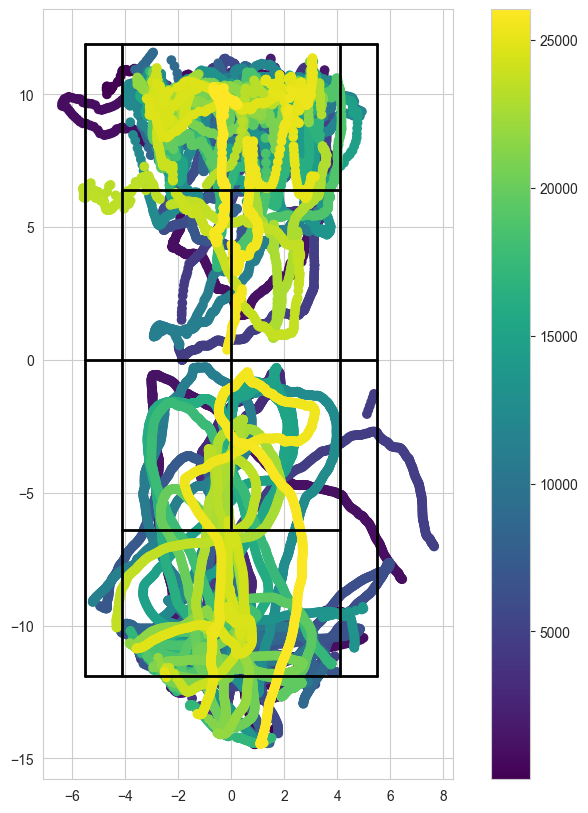

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=df_cam['new_x'], y=df_cam['new_z'], c=df_cam['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

In [14]:
df_cam.loc[(df_cam["new_z"] < 1) & (df_cam["new_z"] > -1)]

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z
2272,1257,5,Person,75.43945,OK,-0.83586,-0.24801,0.69074,0.56123,1.71319,0.56123,-2.042301,1.756837,-0.988982
2274,1258,5,Person,77.39258,OK,-0.82174,-0.24369,0.67862,0.57892,1.71093,0.57892,-2.068335,1.769842,-0.961269
2276,1259,5,Person,78.32031,OK,-0.82151,-0.26351,0.74666,0.60162,1.70921,0.60162,-2.097176,1.785994,-0.916374
2278,1260,5,Person,79.00391,OK,-0.82504,-0.26290,0.74319,0.62752,1.70690,0.62752,-2.126440,1.798221,-0.887301
2280,1261,5,Person,77.24609,OK,-0.83149,-0.26532,0.75137,0.63956,1.70581,0.63956,-2.157358,1.807827,-0.858591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41895,25655,84,Person,45.80078,OK,-0.50347,0.51565,-1.86143,0.56049,1.74832,0.56049,-0.075990,2.032492,0.695313
41897,25656,84,Person,45.80078,OK,-0.50348,0.51596,-1.86134,0.55903,1.74251,0.55903,-0.091680,2.014566,0.633529
41899,25657,84,Person,45.80078,OK,-0.50349,0.51605,-1.86132,0.55723,1.73671,0.55723,-0.106652,1.997011,0.571231
41901,25658,84,Person,45.80078,OK,-0.50348,0.51584,-1.86138,0.55517,1.73090,0.55517,-0.121376,1.979541,0.508720


Wir sehen, dass die Kamera den ersten Spieler sehr gut erkennt, aber der zweite Spieler scheint etwas zu weit vorne zu stehen. 
Wir geben dem zweiten Spieler einen Offset von 2m nach hinten.

Um den Daten aber einen Offset zu geben, beheben wir noch ein anderes Problem. Die Objekte haben viele verschiedene IDs, wir werden diese anhand der Koordianten anpassen.

In [15]:
df_cam["object_id"] = np.where(df_cam["new_z"] < 0, "Player1", "Player2")

### Offset

In [17]:
df_cam.loc[df_cam["object_id"] == "Player2", "new_z"] = df_cam.loc[df_cam["object_id"] == "Player2", "new_z"] + 2

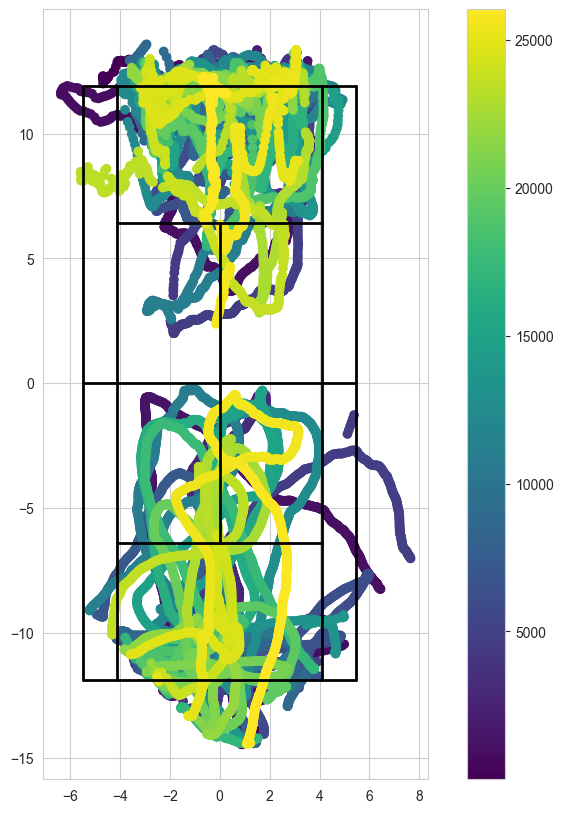

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=df_cam['new_x'], y=df_cam['new_z'], c=df_cam['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

Das Ergebnis sieht nun besser aus, obwohl die bewegung des zweiten Spielers etwas komisch aussieht.
Das liegt wahrscheinlich daran, dass die Kamera auf weitere Entfernung nicht mehr so genau ist.

### Doppelte Frames

Die Kamera gibt die Position für beide Spieler in einer seperaten Zeile aus. Da sie aber im geleichen Frame aufgenommen wurden, können wir diese zusammenführen.

Um Fehler auszuschliessen schneiden wir die Daten anhand der Labels, da wir Start und Endzeitpunkt kennen.

In [19]:
max_label = df_labels["Frame"].max()
min_label = df_labels["Frame"].min()

In [20]:
df_cam = df_cam[(df_cam["frame"] >= min_label) & (df_cam["frame"] <= max_label)]

In [21]:
df_cam[df_cam.isna().any(axis=1)]

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z
22210,13586,Player2,Person,82.42188,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22212,13587,Player2,Person,87.59766,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22214,13588,Player2,Person,87.59766,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22216,13589,Player2,Person,89.59961,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22218,13590,Player2,Person,89.50195,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22220,13591,Player2,Person,90.38086,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN


Die Daten lassens sich aber nicht einfach zum andere Format umwandeln. Das Problem liegt an den vergebenen IDs. Die Kamera vergibt immer neue IDs, wenn ein Objekt nicht mehr erkannt wird. Wir umgehen dass, in dem wir sagen positive z-Koordiante rist Player 2 und negative Player 1. Da die Kamera aber etwas ungenau ist am Netz vorne müssen wir die Daten anpassen.

In [22]:
len(df_cam[df_cam.duplicated(subset=["frame", "object_id"], keep=False)])

68

Glücklicherweise kommt es nur 68 mal vor also entfernen wir diese Frames

In [23]:
df_cam = df_cam.drop_duplicates(subset=["frame", "object_id"], keep=False)

In [24]:
df_cam

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z
521,287,Player1,Person,83.69141,OK,0.01540,-0.04420,0.15406,0.64888,1.99435,0.64888,0.488342,-1.157367,-9.915421
522,287,Player2,Person,32.34863,OK,-0.06328,0.04720,-0.17333,0.61570,1.17692,0.61570,-2.556822,5.167203,11.479640
523,288,Player1,Person,87.69531,OK,0.02580,-0.03045,0.10899,0.66799,1.97376,0.66799,0.487970,-1.155410,-9.916995
524,288,Player2,Person,33.88672,OK,-0.05046,0.03763,-0.13822,0.61899,1.17656,0.61899,-2.551163,5.141961,11.366557
525,289,Player1,Person,87.45117,OK,0.02339,-0.02760,0.09879,0.68904,1.95456,0.68904,0.487290,-1.155982,-9.917908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41443,25418,Player2,Person,53.32031,OK,0.35546,-0.14441,0.56125,0.61038,1.38896,0.61039,0.834903,4.535234,10.239158
41444,25419,Player1,Person,75.58594,OK,1.42219,-0.00269,0.27825,0.71328,1.65808,0.71328,1.689395,0.776300,-2.944103
41445,25419,Player2,Person,54.58984,OK,0.26817,-0.08407,0.33846,0.60976,1.39458,0.60976,0.832179,4.524261,10.182033
41446,25420,Player1,Person,74.56055,OK,1.36259,0.00797,0.23094,0.68662,1.65815,0.68662,1.714517,0.774839,-2.944206


### Duplikate

Vorhin haben wir schon nach Duplikate gesucht, aber nur nach Frames und IDs. Wir betrachten nun die Koordinaten.

In [25]:
df_cam[df_cam.duplicated()]

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z


Glücklicherweise gibt es keine Duplikate.

## NaN Werte

In [26]:
df_cam[df_cam.isna().any(axis=1)]

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z


In [27]:
df_cam_wrangled = df_cam.dropna()

Die Spalten müssen leider entfernen werden auch wenn sehr viele sind.

## Label Dataframe

In [28]:
df_labels.head()

,Frame,Status,Schlag Spieler 1,Schlag Spieler 2,Satz
0,287,Aktiv,Anschlag,NaN,1.0
1,318,NaN,NaN,Fronthand,NaN
2,372,NaN,Fronthand,NaN,NaN
3,421,NaN,NaN,Backhand,NaN
4,469,NaN,Backhand,NaN,NaN


Da das gelabelte Dataframe erzeugt wurde, gehen wir von keinen Fehlern aus

## Merge der beiden Dataframes

In [29]:
df_cam_pivot = pd.pivot(df_cam_wrangled, index="frame", columns="object_id", values=["new_x", "new_y", "new_z", 'vx', 'xy', 'vz', 'width', 'height', 'length'])
#Collapse the MultiIndex
df_cam_pivot.columns = df_cam_pivot.columns.map('_'.join).str.strip()
#Reset Index to get the Name column back
df_cam_pivot = df_cam_pivot.reset_index()

In [30]:
df_cam_pivot.head()

,frame,new_x_Player1,new_x_Player2,new_y_Player1,new_y_Player2,new_z_Player1,new_z_Player2,vx_Player1,vx_Player2,xy_Player1,xy_Player2,vz_Player1,vz_Player2,width_Player1,width_Player2,height_Player1,height_Player2,length_Player1,length_Player2
0,287,0.488342,-2.556822,-1.157367,5.167203,-9.915421,11.479640,0.01540,-0.06328,-0.04420,0.04720,0.15406,-0.17333,0.64888,0.61570,1.99435,1.17692,0.64888,0.61570
1,288,0.487970,-2.551163,-1.155410,5.141961,-9.916995,11.366557,0.02580,-0.05046,-0.03045,0.03763,0.10899,-0.13822,0.66799,0.61899,1.97376,1.17656,0.66799,0.61899
2,289,0.487290,-2.544400,-1.155982,5.116309,-9.917908,11.280055,0.02339,-0.06145,-0.02760,0.04583,0.09879,-0.16830,0.68904,0.62047,1.95456,1.17893,0.68904,0.62047
3,290,0.482031,-2.544177,-1.156393,5.107507,-9.918351,11.270463,0.02728,-0.04928,-0.03218,0.03674,0.11523,-0.13497,0.71109,0.62504,1.95276,1.18399,0.71109,0.62504
4,291,0.477606,-2.544681,-1.157121,5.102722,-9.919782,11.268751,0.01641,-0.04386,-0.01936,0.03270,0.06932,-0.12013,0.73265,0.62681,1.94945,1.17943,0.73265,0.62681


In [31]:
df = pd.merge(df_cam_pivot, df_labels, left_on="frame", right_on="Frame", how="left")
df = df.drop(columns=["Frame"])

In [32]:
df[["Status", "Satz"]] = df[["Status", "Satz"]].ffill()

In [33]:
df = df.loc[df["Status"] != "Inaktiv"]

In [34]:
df["geschwindigkeit_p1"] = np.sqrt(df["vx_Player1"] ** 2 + df["xy_Player1"] ** 2 + df["vz_Player1"] ** 2)
df["geschwindigkeit_p2"] = np.sqrt(df["vx_Player2"] ** 2 + df["xy_Player2"] ** 2 + df["vz_Player2"] ** 2)

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


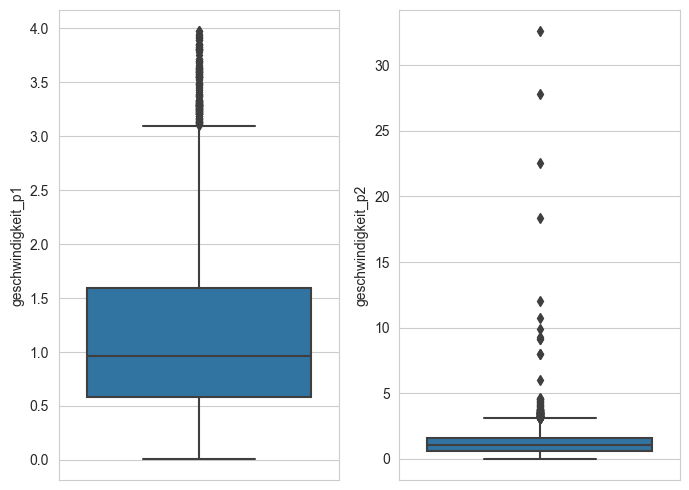

In [35]:
plt.figure(figsize=(7, 5))

plt.subplot(121)
sns.boxplot(y=df["geschwindigkeit_p1"])

plt.subplot(122)
sns.boxplot(y=df["geschwindigkeit_p2"])
plt.tight_layout()
plt.show()

In [36]:
df["geschwindigkeit_p1"] = df["geschwindigkeit_p1"].rolling(5, min_periods=1).median()
df["geschwindigkeit_p2"] = df["geschwindigkeit_p2"].rolling(10, min_periods=1).median()

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


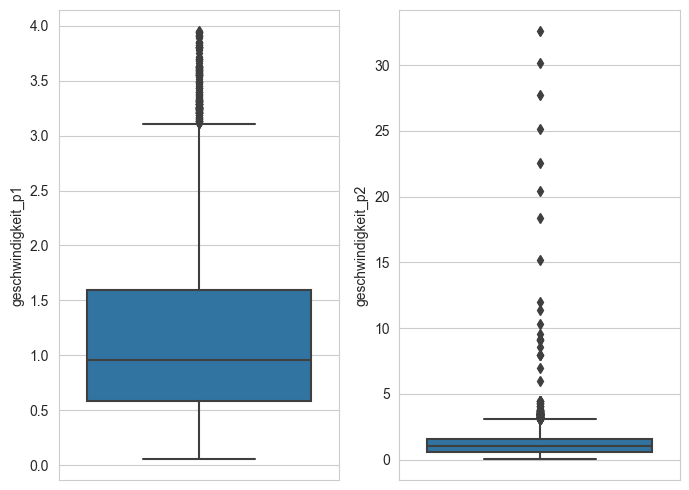

In [37]:
plt.figure(figsize=(7, 5))

plt.subplot(121)
sns.boxplot(y=df["geschwindigkeit_p1"])

plt.subplot(122)
sns.boxplot(y=df["geschwindigkeit_p2"])
plt.tight_layout()
plt.show()

Immer komische Werte bei der Geschwindigkeit

In [38]:
wrong_vel = df.loc[(df["geschwindigkeit_p2"] > 5) ][["new_x_Player2", "new_y_Player2", "new_z_Player2", "geschwindigkeit_p2","geschwindigkeit_p1"]]

In [39]:
vect = wrong_vel[-1:].values - wrong_vel[:1].values
df["geschwindigkeit_p2"].values[(df["geschwindigkeit_p2"].values > 5) ] = np.sqrt(vect[:,0] ** 2 + vect[:,1] ** 2 + vect[:,2] ** 2)

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


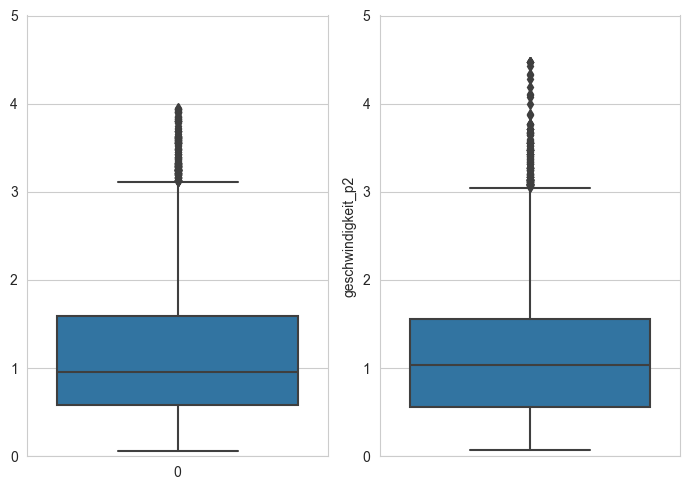

In [40]:
plt.figure(figsize=(7, 5))

plt.subplot(121)
sns.boxplot(df["geschwindigkeit_p1"])
plt.ylim(0, 5)

plt.subplot(122)
sns.boxplot(y=df["geschwindigkeit_p2"])
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

In [41]:
#
df["zone_p1"] = df["new_z_Player1"].apply(zonen)
df["zone_p2"] = df["new_z_Player2"].apply(zonen)
#
df["pos_p1"] = df["new_x_Player1"].apply(position)
df["pos_p2"] = df["new_x_Player2"].apply(position)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5538 entries, 0 to 23973
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   frame               5538 non-null   int64  
 1   new_x_Player1       5449 non-null   float64
 2   new_x_Player2       4787 non-null   float64
 3   new_y_Player1       5449 non-null   float64
 4   new_y_Player2       4787 non-null   float64
 5   new_z_Player1       5449 non-null   float64
 6   new_z_Player2       4787 non-null   float64
 7   vx_Player1          5449 non-null   float64
 8   vx_Player2          4787 non-null   float64
 9   xy_Player1          5449 non-null   float64
 10  xy_Player2          4787 non-null   float64
 11  vz_Player1          5449 non-null   float64
 12  vz_Player2          4787 non-null   float64
 13  width_Player1       5449 non-null   float64
 14  width_Player2       4787 non-null   float64
 15  height_Player1      5449 non-null   float64
 16  height_Pla

In [43]:
df.drop(columns=['vx_Player1', 'vx_Player2', 'xy_Player1', 'xy_Player2', 'vz_Player1', 'vz_Player2'], inplace=True)

In [44]:
df["Status"] = df["Status"].astype("category")
df["Schlag Spieler 1"] = df["Schlag Spieler 1"].astype("category")
df["Schlag Spieler 2"] = df["Schlag Spieler 2"].astype("category")
df["Satz"] = df["Satz"].astype("category")
df["zone_p1"] = df["zone_p1"].astype("category")
df["zone_p2"] = df["zone_p2"].astype("category")
df["pos_p1"] = df["pos_p1"].astype("category")
df["pos_p2"] = df["pos_p2"].astype("category")

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5538 entries, 0 to 23973
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   frame               5538 non-null   int64   
 1   new_x_Player1       5449 non-null   float64 
 2   new_x_Player2       4787 non-null   float64 
 3   new_y_Player1       5449 non-null   float64 
 4   new_y_Player2       4787 non-null   float64 
 5   new_z_Player1       5449 non-null   float64 
 6   new_z_Player2       4787 non-null   float64 
 7   width_Player1       5449 non-null   float64 
 8   width_Player2       4787 non-null   float64 
 9   height_Player1      5449 non-null   float64 
 10  height_Player2      4787 non-null   float64 
 11  length_Player1      5449 non-null   float64 
 12  length_Player2      4787 non-null   float64 
 13  Status              5538 non-null   category
 14  Schlag Spieler 1    75 non-null     category
 15  Schlag Spieler 2    62 non-null     catego

## Explorative Datenanalyse

In [46]:
df.shape

(5538, 23)

In [47]:
df.head(100)

,frame,new_x_Player1,new_x_Player2,new_y_Player1,new_y_Player2,new_z_Player1,new_z_Player2,width_Player1,width_Player2,height_Player1,...,Status,Schlag Spieler 1,Schlag Spieler 2,Satz,geschwindigkeit_p1,geschwindigkeit_p2,zone_p1,zone_p2,pos_p1,pos_p2
0,287,0.488342,-2.556822,-1.157367,5.167203,-9.915421,11.479640,0.64888,0.61570,1.99435,...,Aktiv,Anschlag,NaN,1.0,0.161013,0.190461,Offensiv,Neutral,Mitte,Links
1,288,0.487970,-2.551163,-1.155410,5.141961,-9.916995,11.366557,0.66799,0.61899,1.97376,...,Aktiv,NaN,NaN,1.0,0.138540,0.171170,Offensiv,Neutral,Mitte,Links
2,289,0.487290,-2.544400,-1.155982,5.116309,-9.917908,11.280055,0.68904,0.62047,1.95456,...,Aktiv,NaN,NaN,1.0,0.116067,0.184936,Offensiv,Neutral,Mitte,Links
3,290,0.482031,-2.544177,-1.156393,5.107507,-9.918351,11.270463,0.71109,0.62504,1.95276,...,Aktiv,NaN,NaN,1.0,0.119389,0.168407,Offensiv,Neutral,Mitte,Links
4,291,0.477606,-2.544681,-1.157121,5.102722,-9.919782,11.268751,0.73265,0.62681,1.94945,...,Aktiv,NaN,NaN,1.0,0.116067,0.151878,Offensiv,Neutral,Mitte,Links
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,382,2.759237,0.226410,-1.838264,5.150879,-11.095435,12.121358,0.68311,0.75847,1.76520,...,Aktiv,NaN,NaN,1.0,0.883059,0.423503,Neutral,Defensiv,Rechts,Mitte
96,383,2.755462,0.212789,-1.835199,5.158845,-11.083066,12.172864,0.67856,0.76611,1.76421,...,Aktiv,NaN,NaN,1.0,0.812744,0.391667,Neutral,Defensiv,Rechts,Mitte
97,384,2.751136,0.205017,-1.833197,5.161716,-11.074870,12.191233,0.68254,0.77897,1.76047,...,Aktiv,NaN,NaN,1.0,0.740499,0.361876,Neutral,Defensiv,Rechts,Mitte
98,385,2.747896,0.199952,-1.831858,5.162492,-11.069841,12.193130,0.69038,0.78717,1.75721,...,Aktiv,NaN,NaN,1.0,0.672104,0.332086,Neutral,Defensiv,Rechts,Mitte


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5538 entries, 0 to 23973
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   frame               5538 non-null   int64   
 1   new_x_Player1       5449 non-null   float64 
 2   new_x_Player2       4787 non-null   float64 
 3   new_y_Player1       5449 non-null   float64 
 4   new_y_Player2       4787 non-null   float64 
 5   new_z_Player1       5449 non-null   float64 
 6   new_z_Player2       4787 non-null   float64 
 7   width_Player1       5449 non-null   float64 
 8   width_Player2       4787 non-null   float64 
 9   height_Player1      5449 non-null   float64 
 10  height_Player2      4787 non-null   float64 
 11  length_Player1      5449 non-null   float64 
 12  length_Player2      4787 non-null   float64 
 13  Status              5538 non-null   category
 14  Schlag Spieler 1    75 non-null     category
 15  Schlag Spieler 2    62 non-null     catego

In [49]:
df.describe(include="all")

,frame,new_x_Player1,new_x_Player2,new_y_Player1,new_y_Player2,new_z_Player1,new_z_Player2,width_Player1,width_Player2,height_Player1,...,Status,Schlag Spieler 1,Schlag Spieler 2,Satz,geschwindigkeit_p1,geschwindigkeit_p2,zone_p1,zone_p2,pos_p1,pos_p2
count,5538.000000,5449.000000,4787.000000,5449.000000,4787.000000,5449.000000,4787.000000,5449.000000,4787.000000,5449.000000,...,5538,75,62,5538.0,5465.000000,5284.000000,5538,5538,5538,5538
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,3,3,3.0,NaN,NaN,4,4,3,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Aktiv,Anschlag,Fronthand,3.0,NaN,NaN,Offensiv,Defensiv,Mitte,Mitte
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5538,28,31,2987.0,NaN,NaN,3282,2217,3734,3055
mean,11106.260563,-0.400948,0.684688,-1.312534,4.773249,-10.116067,11.067450,0.825033,0.713452,1.756707,...,NaN,NaN,NaN,NaN,1.167847,1.168838,NaN,NaN,NaN,NaN
std,7612.009150,1.547804,1.874862,0.576069,0.554516,1.769867,1.721171,0.177810,0.085318,0.079917,...,NaN,NaN,NaN,NaN,0.771883,0.758768,NaN,NaN,NaN,NaN
min,287.000000,-4.152590,-6.365507,-2.564604,2.083407,-12.531677,2.003769,0.503380,0.503640,1.114770,...,NaN,NaN,NaN,NaN,0.059214,0.071474,NaN,NaN,NaN,NaN
25%,3905.250000,-1.378311,-0.349279,-1.711116,4.583699,-11.308802,10.526656,0.702420,0.658070,1.715220,...,NaN,NaN,NaN,NaN,0.582690,0.563907,NaN,NaN,NaN,NaN
50%,10420.500000,-0.477857,0.955436,-1.386131,4.960105,-10.444174,11.655178,0.792780,0.706660,1.762010,...,NaN,NaN,NaN,NaN,0.961369,1.036514,NaN,NaN,NaN,NaN
75%,18442.750000,0.375747,2.088762,-1.099705,5.131891,-9.626821,12.186909,0.903750,0.759730,1.798080,...,NaN,NaN,NaN,NaN,1.594536,1.558026,NaN,NaN,NaN,NaN


Wir machen eine kurze Analyse mit describe, um zu sehen ob es auffällige Werte gibt.
- Wir haben für die Analyse 23975 Frames, wo bei ein paar wegfallen, weil die Kamera die Objekte nicht erkannt hat.
- Bei den Kooridante fallen geraden keine auffälligen Werte auf.
- Bei den heights sieht man das Spieler 1 grösser ist als Spieler 2.
- Das der Status mehrheitlich inaktiv ist, ist auch logisch da unterbrüche teilweise etwas länger dauern. Wie lassen dennoch die inactiven Frames im Spiel, um vileicht ein Muster zu erkennen ob der Spieler inaktiv ist.
- Was bei der Aufnahme auch auffgefallen ist, dass der Spieler 1 viel das Spiel startet. 
- Bei den Geschwindigkeiten scheint es ein paar Ausreisser zu geben, die noch untersucht werden müssen.

## Vergleich der Geschwindigkeiten der Spieler

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


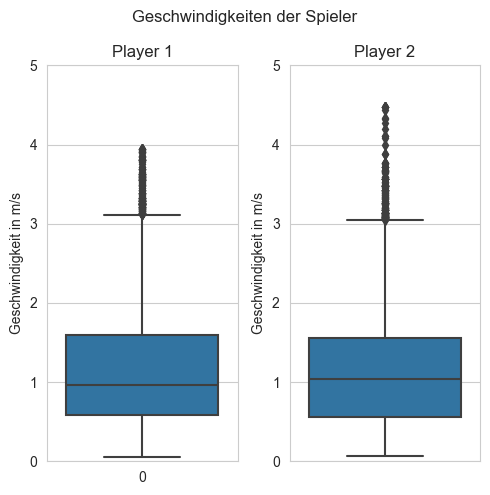

In [50]:
plt.figure(figsize=(5, 5))
plt.suptitle("Geschwindigkeiten der Spieler", fontsize=12)

plt.subplot(121)
sns.boxplot(df["geschwindigkeit_p1"])
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)
plt.title("Player 1")

plt.subplot(122)
sns.boxplot(y=df["geschwindigkeit_p2"])
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)
plt.title("Player 2")
plt.tight_layout()
plt.show()

## Position auf dem Feld

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


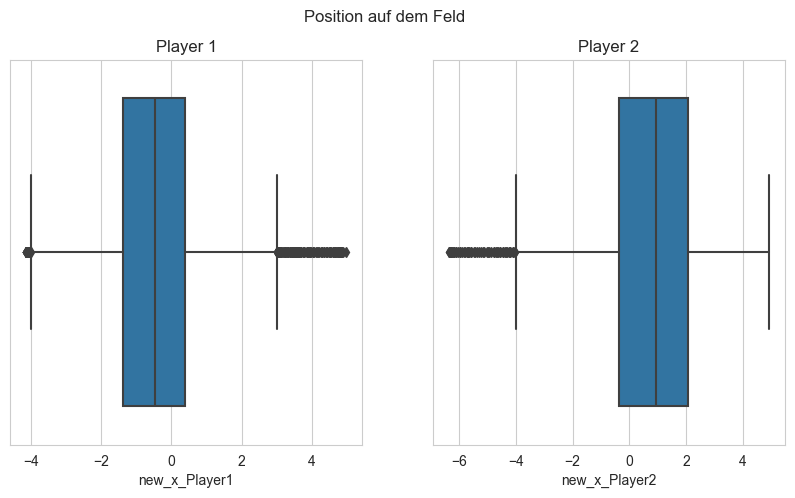

In [51]:
plt.figure(figsize=(10, 5))
plt.suptitle("Position auf dem Feld", fontsize=12)
plt.subplot(121)
plt.title("Player 1")
sns.boxplot(df, x="new_x_Player1")
plt.subplot(122)
plt.title("Player 2")
sns.boxplot(df, x="new_x_Player2")
plt.show()

## Geschwindigkeit über die Zeit

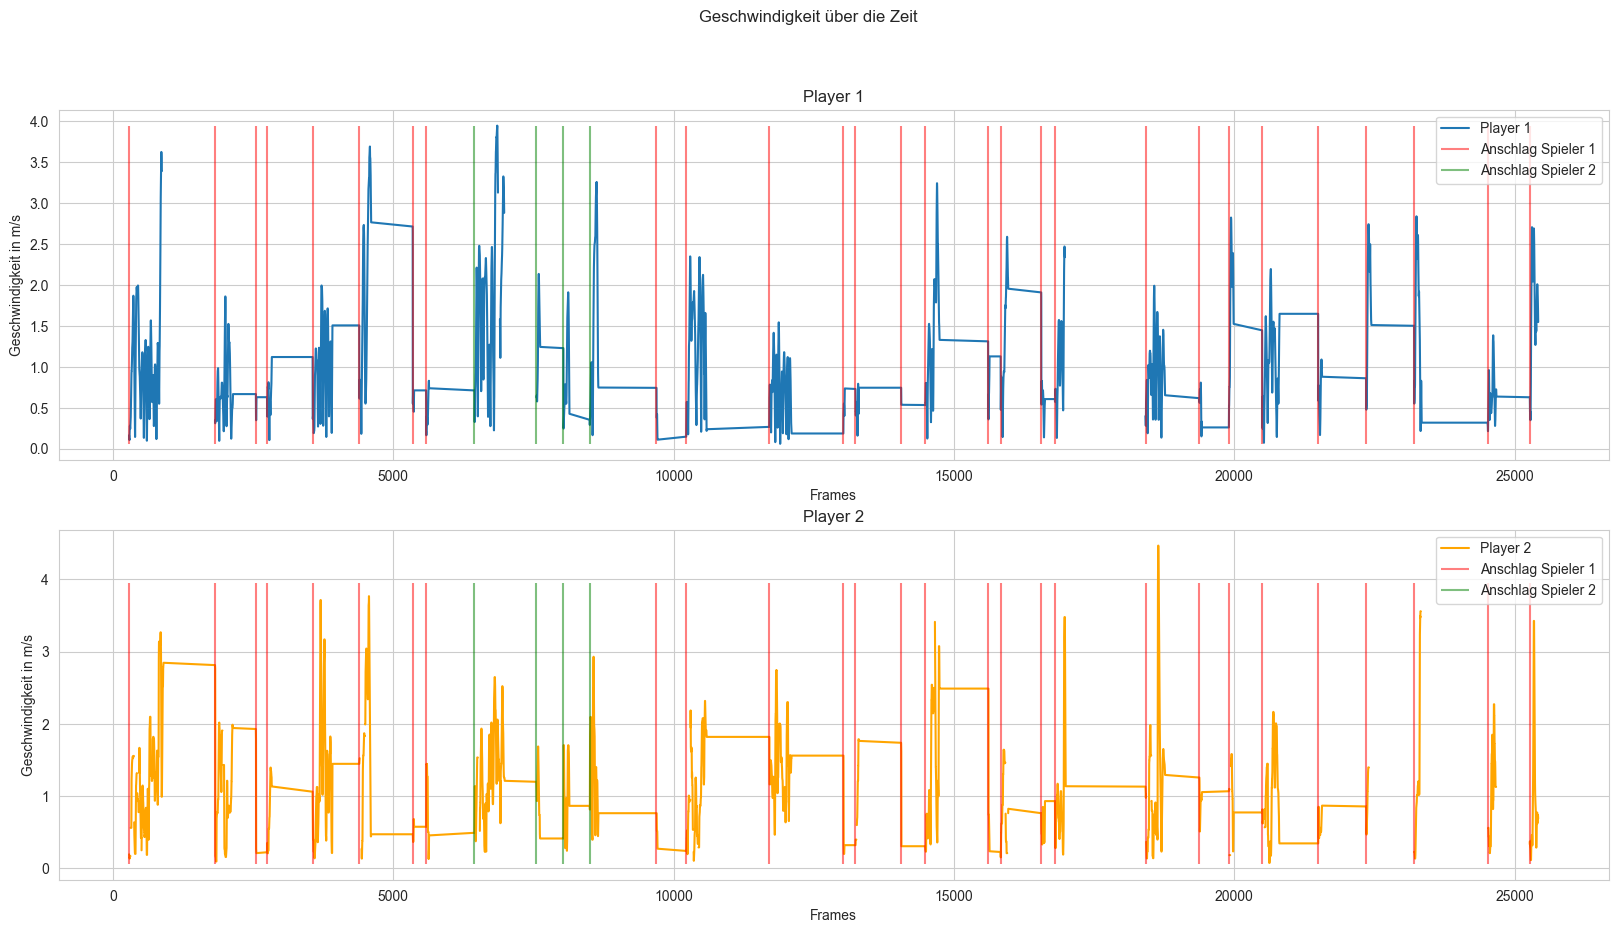

In [52]:
plt.subplots(2,1,figsize=(20, 10))
plt.suptitle("Geschwindigkeit über die Zeit", fontsize=12)
#Subplot für die Geschwindigkeit von Spieler 1
plt.subplot(211)
plt.title("Player 1")
plt.plot(df["frame"], df["geschwindigkeit_p1"], label="Player 1")
plt.xlabel("Frames")
plt.ylabel("Geschwindigkeit in m/s")
plt.vlines(df.loc[df['Schlag Spieler 1'] == "Anschlag"]["frame"], ymin=df["geschwindigkeit_p1"].min(), ymax=df["geschwindigkeit_p1"].max(), color="red", label="Anschlag Spieler 1", alpha=0.5)
plt.vlines(df.loc[df['Schlag Spieler 2'] == "Anschlag"]["frame"], ymin=df["geschwindigkeit_p1"].min(), ymax=df["geschwindigkeit_p1"].max(), color="green", label="Anschlag Spieler 2", alpha=0.5)
plt.legend()
#Subplot für die Geschwindigkeit von Spieler 2
plt.subplot(212)
plt.title("Player 2")
plt.plot(df["frame"], df["geschwindigkeit_p2"], label="Player 2", c = "orange")
plt.xlabel("Frames")
plt.ylabel("Geschwindigkeit in m/s")
# Vertikale Linien für die Anschläge von Spieler 1 in rot 
plt.vlines(df.loc[df['Schlag Spieler 1'] == "Anschlag"]["frame"], ymin=df["geschwindigkeit_p1"].min(), ymax=df["geschwindigkeit_p1"].max(), color="red", label="Anschlag Spieler 1", alpha=0.5)
# Vertikale Linien für die Anschläge von Spieler 1 in grün
plt.vlines(df.loc[df['Schlag Spieler 2'] == "Anschlag"]["frame"], ymin=df["geschwindigkeit_p1"].min(), ymax=df["geschwindigkeit_p1"].max(), color="green", label="Anschlag Spieler 2", alpha=0.5)
plt.legend()
plt.show()

Deutlich zu sehen ist, das Spieler 1 viel mehr Anschläge macht als Spieler 2. Das ist auch in der Videoaufnahme zu sehen. Die Löcher oder horizontalen Linien sind keine Fehler, sondern Abschnitte bei denen das Spiel unterbrochen war. Wir teilen den Datensatz in drei Teile auf, um zu sehen wie sich die Spieler verhalten.
Die Hypothese ist natürlich das die Spieler müde werden und das Spiel langsamer wird.

### Analyse der drei Sätze

In [53]:
df_satz1 = df.loc[df["Satz"] == 1]
df_satz2 = df.loc[df["Satz"] == 2]
df_satz3 = df.loc[df["Satz"] == 3]

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

(0.0, 5.0)

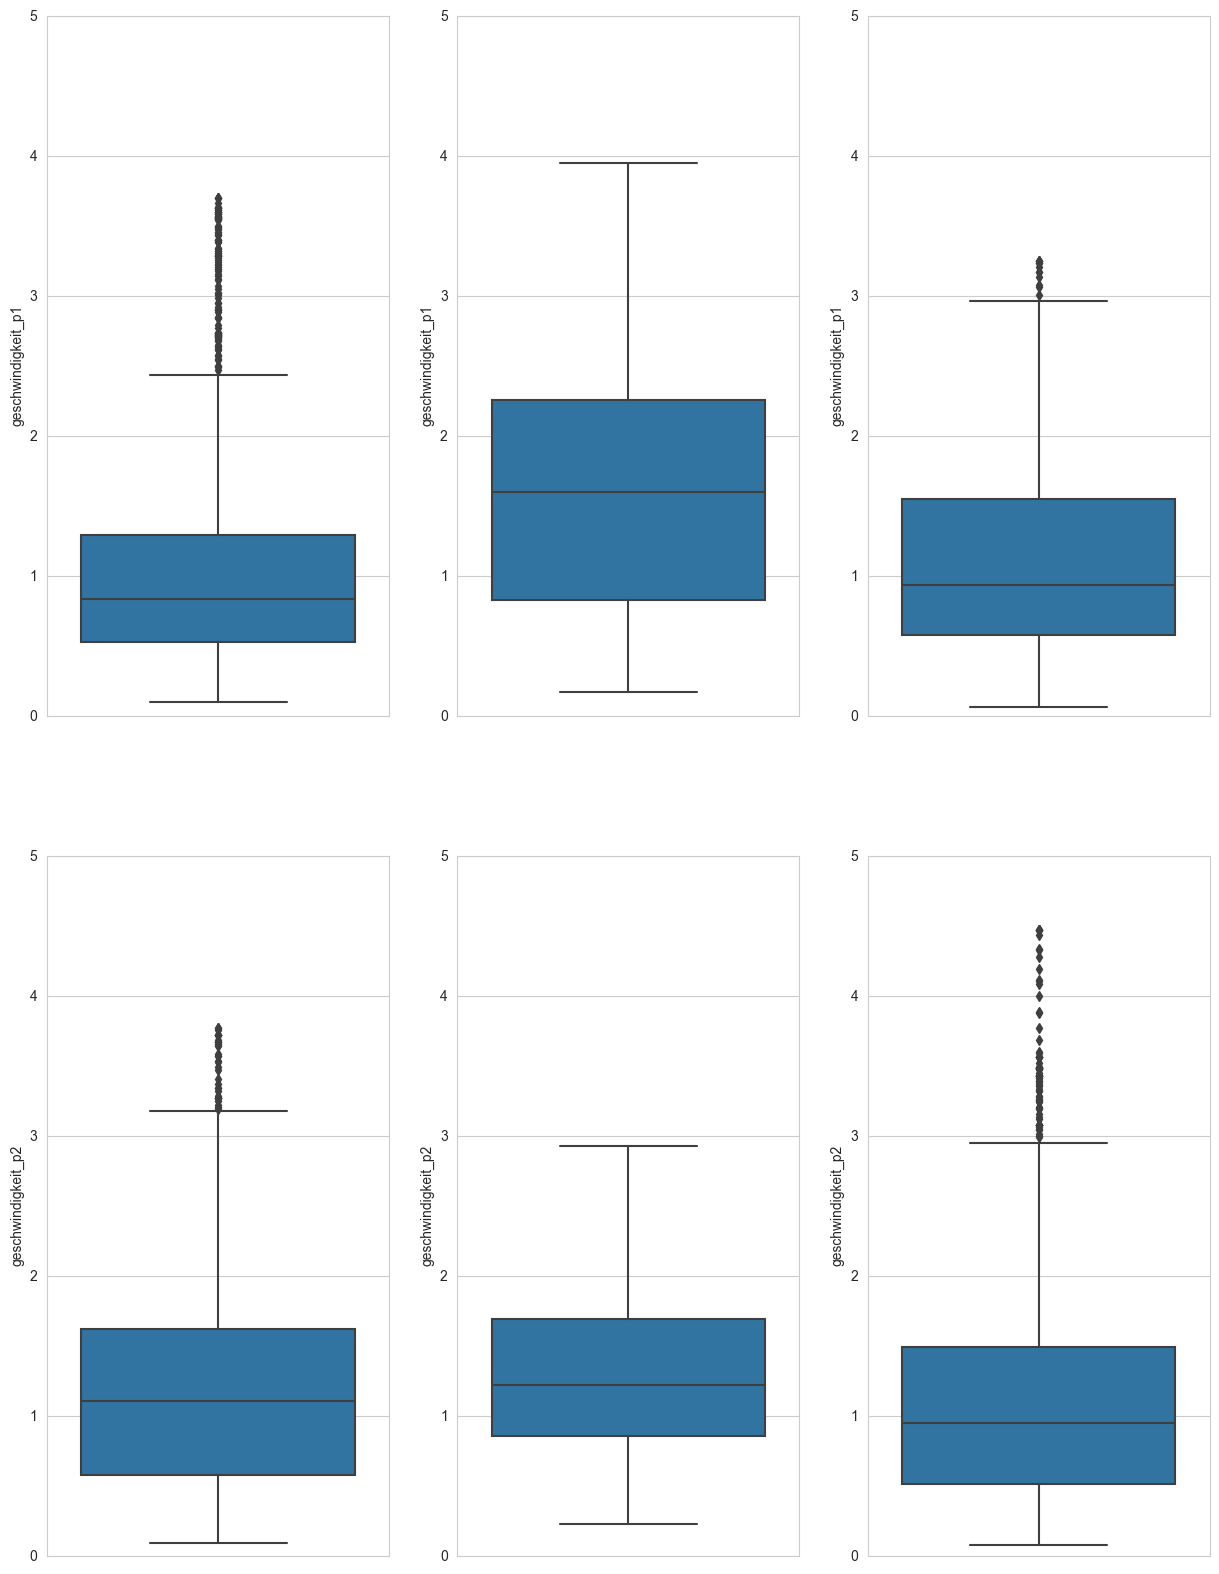

In [54]:
plt.figure(figsize=(15, 20))

plt.subplot(231)
sns.boxplot(y="geschwindigkeit_p1", data=df_satz1)
plt.ylim(0, 5)
plt.subplot(232)
sns.boxplot(y="geschwindigkeit_p1", data=df_satz2)
plt.ylim(0, 5)
plt.subplot(233)
sns.boxplot(y="geschwindigkeit_p1", data=df_satz3)
plt.ylim(0, 5)
plt.subplot(234)
sns.boxplot(y="geschwindigkeit_p2", data=df_satz1)
plt.ylim(0, 5)
plt.subplot(235)
sns.boxplot(y="geschwindigkeit_p2", data=df_satz2)
plt.ylim(0, 5)
plt.subplot(236)
sns.boxplot(y="geschwindigkeit_p2", data=df_satz3)
plt.ylim(0, 5)

## Zone auf dem Feld

In [55]:
test = df.loc[df["frame"] <= 1000]

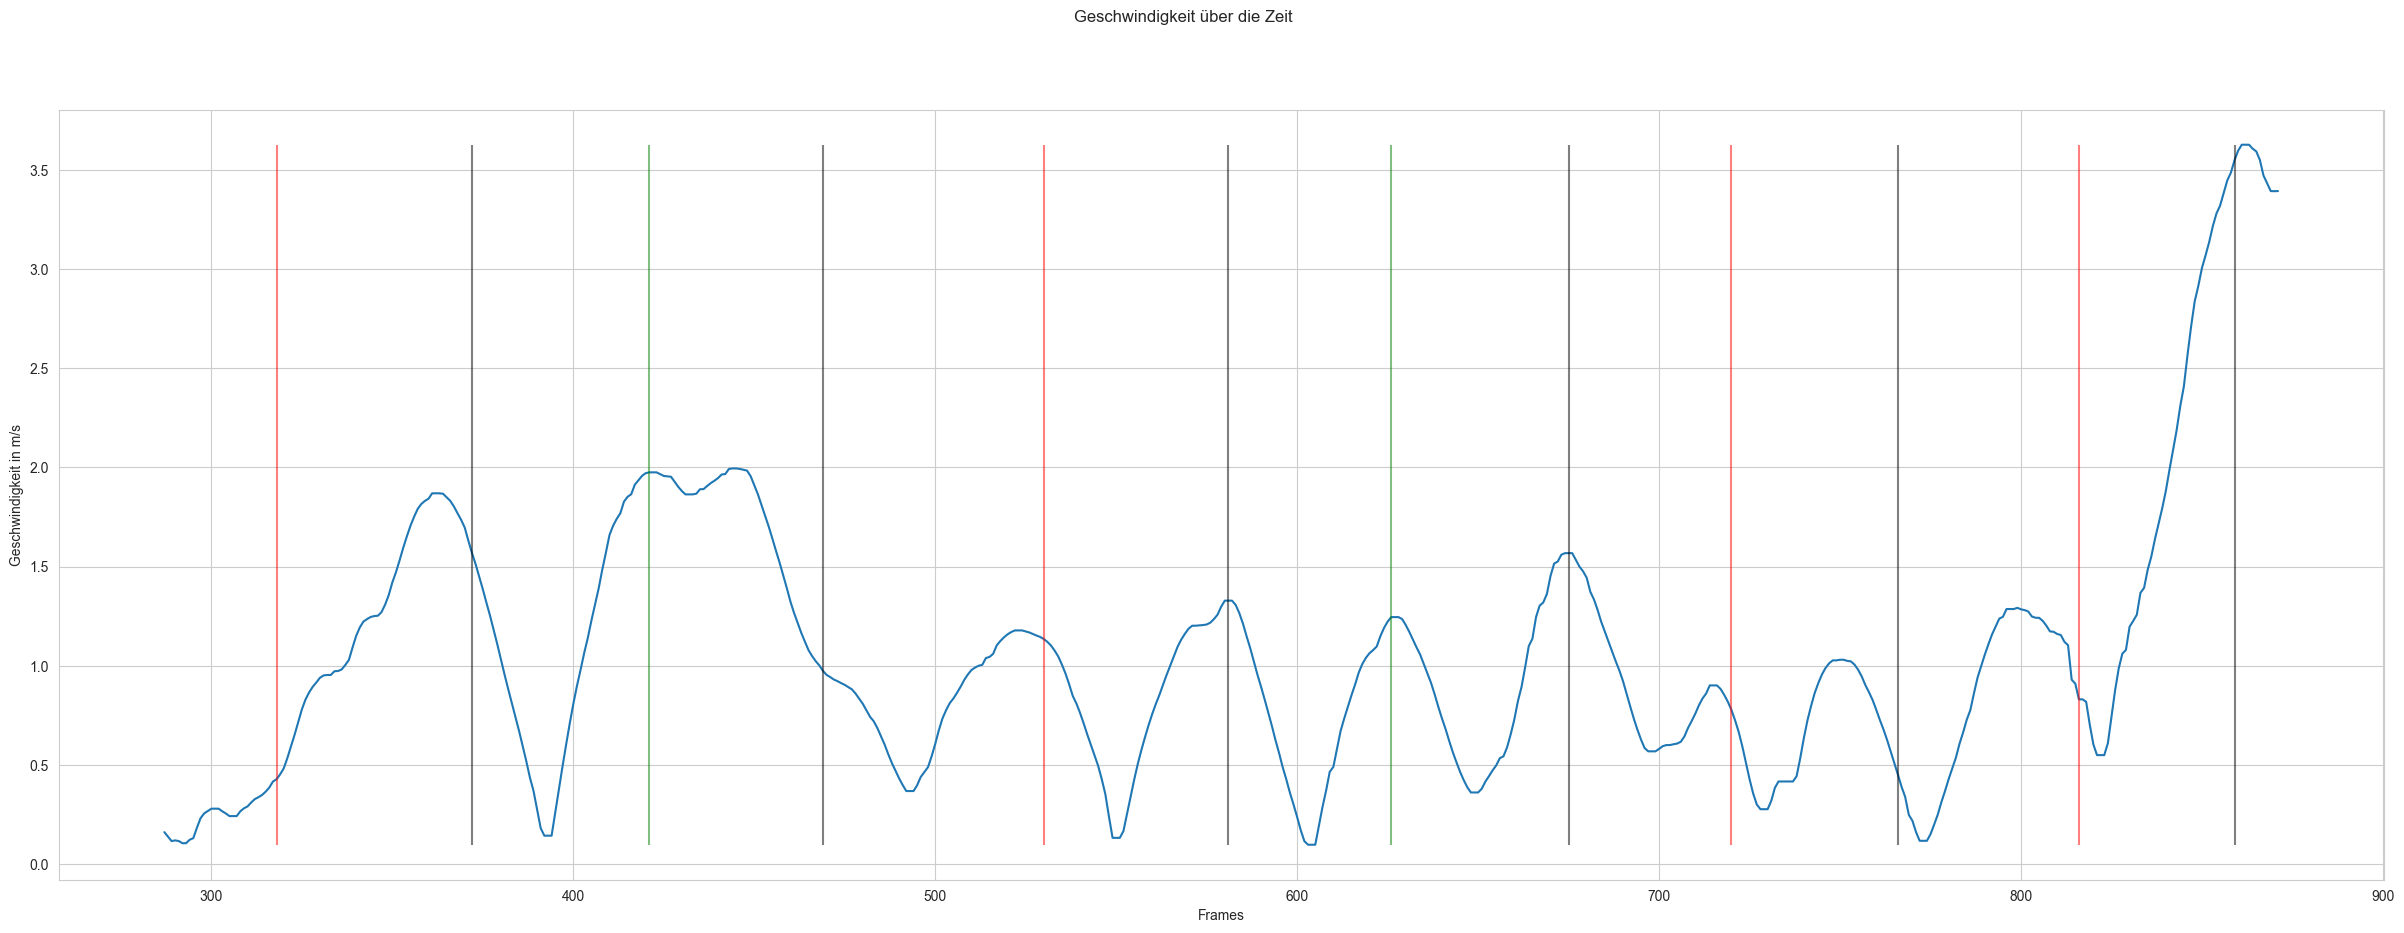

In [56]:
plt.figure(figsize=(30, 10))
plt.suptitle("Geschwindigkeit über die Zeit", fontsize=12)
plt.plot(test["frame"], test["geschwindigkeit_p1"], label="Player 1")
plt.xlabel("Frames")
plt.ylabel("Geschwindigkeit in m/s")
plt.vlines(test.loc[df['Schlag Spieler 2'] == "Fronthand"]["frame"], ymin=test["geschwindigkeit_p1"].min(), ymax=test["geschwindigkeit_p1"].max(), color="red", label="Anschlag Spieler 1", alpha=0.5)
plt.vlines(test.loc[df['Schlag Spieler 2'] == "Backhand"]["frame"], ymin=test["geschwindigkeit_p1"].min(), ymax=test["geschwindigkeit_p1"].max(), color="green", label="Anschlag Spieler 1", alpha=0.5)

plt.vlines(test.loc[df['Schlag Spieler 1'] == "Fronthand"]["frame"], ymin=test["geschwindigkeit_p1"].min(), ymax=test["geschwindigkeit_p1"].max(), color="black", label="Anschlag Spieler 1", alpha=0.5)
plt.vlines(test.loc[df['Schlag Spieler 1'] == "Backhand"]["frame"], ymin=test["geschwindigkeit_p1"].min(), ymax=test["geschwindigkeit_p1"].max(), color="black", label="Anschlag Spieler 1", alpha=0.5)

plt.show()

In [57]:
df.loc[df["new_z_Player1"] > -3]

,frame,new_x_Player1,new_x_Player2,new_y_Player1,new_y_Player2,new_z_Player1,new_z_Player2,width_Player1,width_Player2,height_Player1,...,Status,Schlag Spieler 1,Schlag Spieler 2,Satz,geschwindigkeit_p1,geschwindigkeit_p2,zone_p1,zone_p2,pos_p1,pos_p2
23959,25405,1.043877,0.620153,0.774472,4.480267,-2.996665,10.062264,0.74252,0.58183,1.66983,...,Aktiv,NaN,NaN,3.0,1.989431,0.618725,Sehr Offensiv,Offensiv,Mitte,Mitte
23960,25406,1.103454,0.615162,0.778201,4.519847,-2.971900,10.194437,0.71197,0.57738,1.66769,...,Aktiv,NaN,NaN,3.0,1.989431,0.618725,Sehr Offensiv,Offensiv,Mitte,Mitte
23961,25407,1.157355,0.612364,0.782053,4.542900,-2.953213,10.254238,0.69418,0.58189,1.66769,...,Aktiv,NaN,NaN,3.0,1.969706,0.658192,Sehr Offensiv,Offensiv,Mitte,Mitte
23962,25408,1.210379,0.613348,0.784135,4.540215,-2.945603,10.211091,0.69404,0.59247,1.66656,...,Aktiv,NaN,NaN,3.0,1.967172,0.741034,Sehr Offensiv,Offensiv,Mitte,Mitte
23963,25409,1.266684,0.629037,0.784726,4.534741,-2.945741,10.180678,0.71058,0.60544,1.66408,...,Aktiv,NaN,NaN,3.0,1.941473,0.736733,Sehr Offensiv,Offensiv,Mitte,Mitte
23964,25410,1.325719,0.661880,0.784324,4.532744,-2.950009,10.179189,0.73111,0.61318,1.66111,...,Aktiv,NaN,NaN,3.0,1.899755,0.732493,Sehr Offensiv,Offensiv,Mitte,Mitte
23965,25411,1.377799,0.674488,0.783633,4.534018,-2.954275,10.198016,0.74772,0.61554,1.65911,...,Aktiv,NaN,NaN,3.0,1.865474,0.736416,Sehr Offensiv,Offensiv,Mitte,Mitte
23966,25412,1.438505,0.679751,0.782970,4.534550,-2.955033,10.206271,0.76375,0.61552,1.65537,...,Aktiv,NaN,NaN,3.0,1.838849,0.736416,Sehr Offensiv,Offensiv,Mitte,Mitte
23967,25413,1.479544,0.698632,0.782372,4.535141,-2.955591,10.216554,0.77908,0.61607,1.65784,...,Aktiv,NaN,NaN,3.0,1.800638,0.736416,Sehr Offensiv,Offensiv,Mitte,Mitte
23968,25414,1.519950,0.726479,0.781287,4.535594,-2.956731,10.225604,0.78451,0.61564,1.65828,...,Aktiv,NaN,NaN,3.0,1.798243,0.736416,Sehr Offensiv,Offensiv,Rechts,Mitte


### Spieler positionierung

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


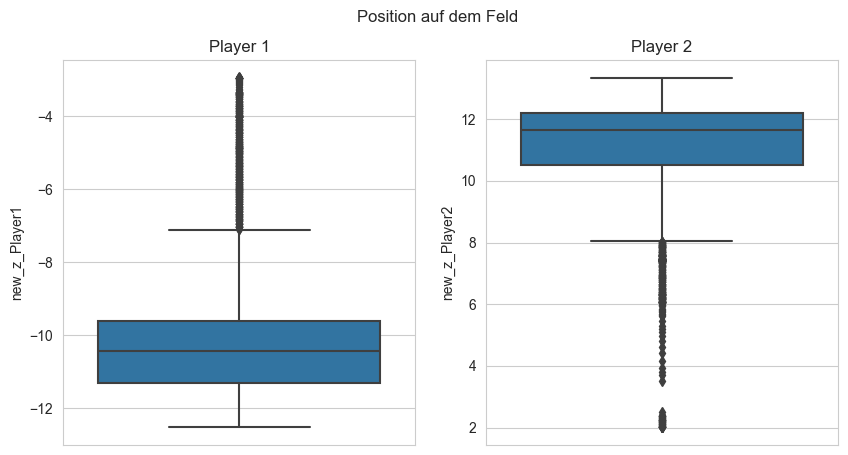

In [58]:
plt.figure(figsize=(10, 5))
plt.suptitle("Position auf dem Feld", fontsize=12)
plt.subplot(121)
plt.title("Player 1")
sns.boxplot(df, y="new_z_Player1")
plt.subplot(122)
plt.title("Player 2")
sns.boxplot(df, y="new_z_Player2")
plt.show()

### Der Spieler steht breiter während er in ruhe ist

In [59]:
df.columns

Index(['frame', 'new_x_Player1', 'new_x_Player2', 'new_y_Player1',
       'new_y_Player2', 'new_z_Player1', 'new_z_Player2', 'width_Player1',
       'width_Player2', 'height_Player1', 'height_Player2', 'length_Player1',
       'length_Player2', 'Status', 'Schlag Spieler 1', 'Schlag Spieler 2',
       'Satz', 'geschwindigkeit_p1', 'geschwindigkeit_p2', 'zone_p1',
       'zone_p2', 'pos_p1', 'pos_p2'],
      dtype='object')

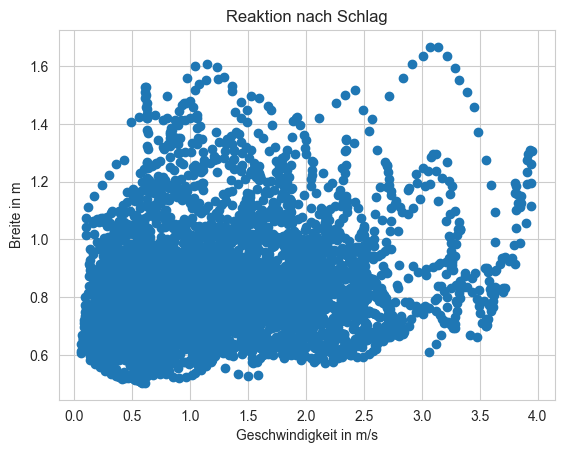

In [60]:
plt.scatter(df["geschwindigkeit_p1"], df["width_Player1"])
plt.title("Reaktion nach Schlag")
plt.xlabel("Geschwindigkeit in m/s")
plt.ylabel("Breite in m")
plt.show()

### Spieler position nach Schlag des Gegners

In [61]:
p2_schlag =df.loc[(df["Schlag Spieler 2"] == "Anschlag") | (df["Schlag Spieler 2"] == "Fronthand") | (df["Schlag Spieler 2"] == "Backhand")][["new_x_Player1", "new_x_Player2", "new_z_Player1","new_z_Player2"]]

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

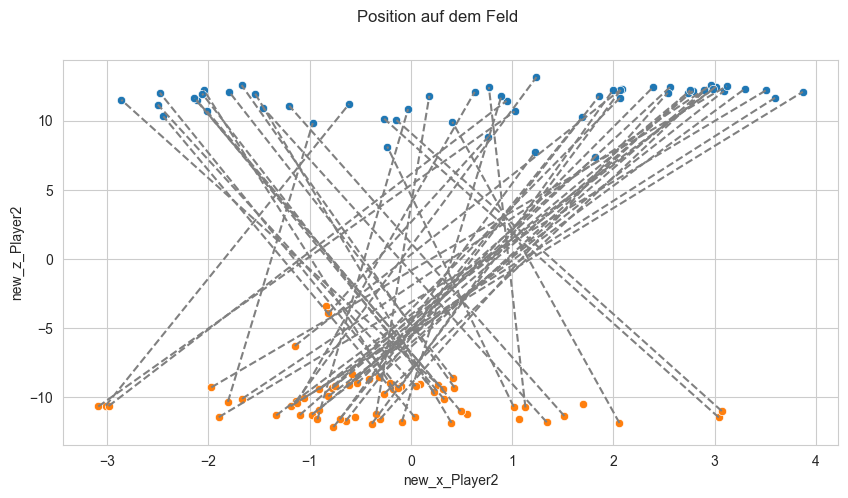

In [62]:
plt.figure(figsize=(10, 5))
plt.suptitle("Position auf dem Feld", fontsize=12)
sns.scatterplot(x="new_x_Player2", y="new_z_Player2", data=p2_schlag)
sns.scatterplot(x="new_x_Player1", y="new_z_Player1", data=p2_schlag)
# Verbindung der Punkte in derselben Zeile
for i in range(len(p2_schlag)):
    plt.plot([p2_schlag.iloc[i]['new_x_Player1'], p2_schlag.iloc[i]['new_x_Player2']],
             [p2_schlag.iloc[i]['new_z_Player1'], p2_schlag.iloc[i]['new_z_Player2']], 
             color='gray', linestyle='--')

plt.show()

In [63]:
# Winkelberechnung für jede Zeile und Hinzufügen zur DataFrame
p2_schlag['winkel'] = p2_schlag.apply(calculate_angle, axis=1)

In [64]:
p1_schlag =df.loc[(df["Schlag Spieler 1"] == "Anschlag") | (df["Schlag Spieler 1"] == "Fronthand") | (df["Schlag Spieler 1"] == "Backhand")][["new_x_Player1", "new_x_Player2", "new_z_Player1","new_z_Player2"]]
# Winkelberechnung für jede Zeile und Hinzufügen zur DataFrame
p1_schlag['winkel'] = p1_schlag.apply(calculate_angle, axis=1)

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

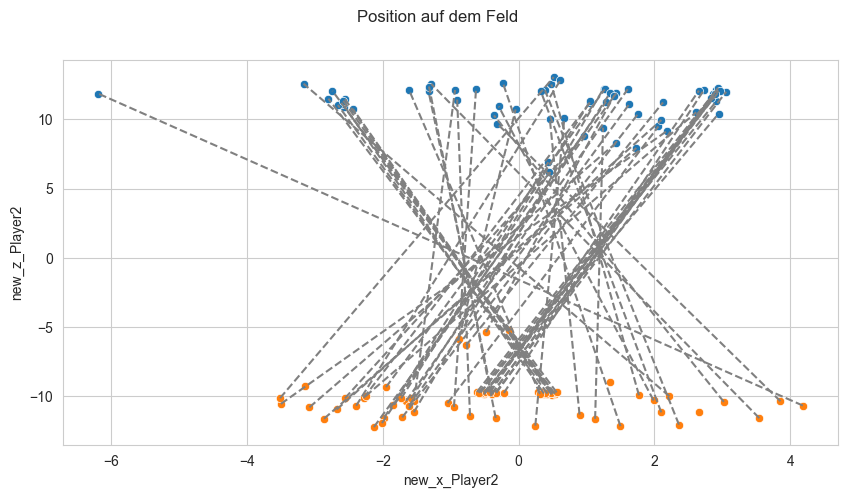

In [65]:
plt.figure(figsize=(10, 5))
plt.suptitle("Position auf dem Feld", fontsize=12)
sns.scatterplot(x="new_x_Player2", y="new_z_Player2", data=p1_schlag)
sns.scatterplot(x="new_x_Player1", y="new_z_Player1", data=p1_schlag)
# Verbindung der Punkte in derselben Zeile
for i in range(len(p1_schlag)):
    plt.plot([p1_schlag.iloc[i]['new_x_Player1'], p1_schlag.iloc[i]['new_x_Player2']],
             [p1_schlag.iloc[i]['new_z_Player1'], p1_schlag.iloc[i]['new_z_Player2']], 
             color='gray', linestyle='--')

plt.show()

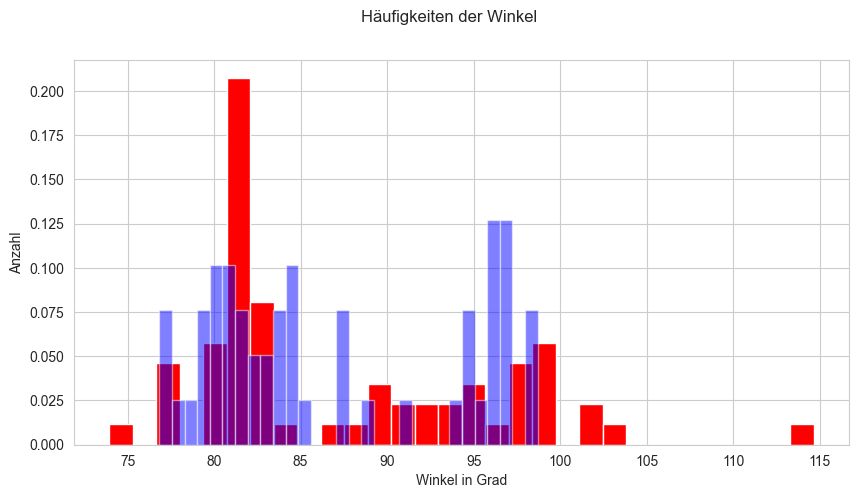

In [66]:
plt.figure(figsize=(10, 5))
plt.suptitle("Häufigkeiten der Winkel", fontsize=12)
plt.hist(p1_schlag["winkel"], bins=30, color="red", density=True)
plt.hist(p2_schlag["winkel"], bins=30, color="blue", alpha=0.5, density=True)
plt.xlabel("Winkel in Grad")
plt.ylabel("Anzahl")
plt.show()

In [67]:
p1_schlag["abs_winkel"] = np.where(p1_schlag["winkel"] < 90 , p1_schlag["winkel"], 180 - p1_schlag["winkel"])
p2_schlag["abs_winkel"] = np.where(p2_schlag["winkel"] < 90 , p2_schlag["winkel"], 180 - p2_schlag["winkel"])

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Axes: xlabel='new_x_Player2', ylabel='abs_winkel'>

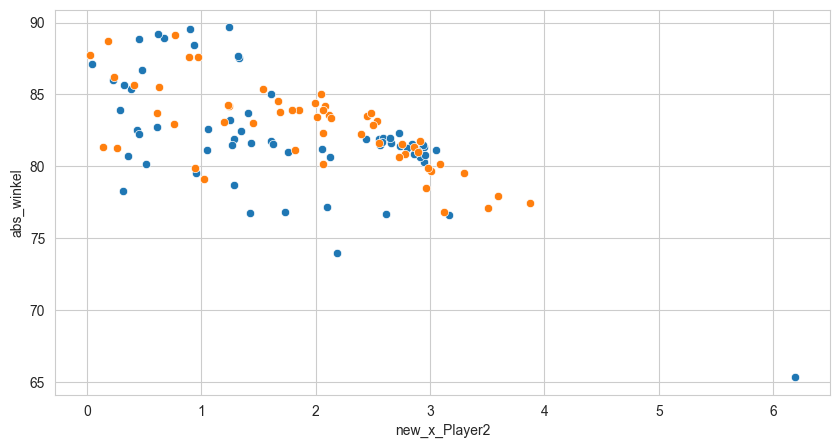

In [68]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=abs(p1_schlag["new_x_Player2"]), y="abs_winkel", data=p1_schlag)
sns.scatterplot(x=abs(p2_schlag["new_x_Player2"]), y="abs_winkel", data=p2_schlag)